In [1]:
!conda install -y -c conda-forge pyarrow python-snappy

Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: failed with repodata from current_repodata.json, will retry with next repodata source.
Solving environment: done

## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - pyarrow
    - python-snappy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    arrow-cpp-3.0.0            |py38h140c071_10_cpu        21.6 MB  conda-forge
    aws-c-cal-0.4.5            |       h76129ab_8          35 KB  conda-forge
    aws-c-common-0.5.2         |       h7f98852_0         165 KB  conda-forge
    aws-c-event-stream-0.2.7   |       h6bac3ce_1          47 KB  conda-forge
    aws-c-io-0.9.1             |       ha5b09cb_1         119 KB  conda-forge
    aws-checksums-0.1.11       |       h99e32c3_3          50 KB  conda-forge
    aws-sdk-cpp-1.8.151        |       hceb1b1e_1

# Initialization

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import time
from datetime import datetime, timedelta

In [3]:
# Plotting initialization
import seaborn as sns
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline

# Initialize style
plt.style.use("acm_ieee_latex_pubstyle.txt")

SINGLE_COLUMN = SINGLE_WIDTH = 8.0
DOUBLE_COLUMN = DOUBLE_WIDTH = 16.0

def width_height(width=SINGLE_COLUMN, height=None, columns=1, rows=1):
    """Width driven sizing for seaborn multi-grid layouts
    
    Derive height & aspect kwargs for facetgrid, pairgrid & friends with a target sizing
    in terms of width and height.  Convenient for creating figures that has
    to be fit into a certain width, while maintaining the correct aspect ratios of the fonts.
    Call this function to derive the height & aspect
    
    Currently, ACM & IEEE latex, single column figure defaults to a width of 8inch
    and the double column figure defaults to a width of 8 inch for the correct text scaling
    
    Usage:
    - sns.FacetGrid( ... , **width_height())
    - sns.PairGrid( ..., **width_height(columns=X, rows=Y))

    :param width: target width in inches (4 inch for a single column figure is default)
    :param height: target heigth in inches (width * 3/4 - golden ratio is the default)
    :param columns: target # of columns for facetgrid
    :param rows: target # of rows for facetgrid
    """
    if height is None:
        height = width * 3/4
    ratio = float(width) / (float(height) / float(rows))
    return {"height": (float(width) / ratio), "aspect": ratio / float(columns)}

In [4]:
# Dask setup block
import os
import pwd
import glob
import pandas as pd
from distributed import LocalCluster, Client
import dask
import dask.dataframe as dd

# Cleanup
try:
    client.shutdown()
    client.close()
except Exception as e:
    pass

# Configuration
LOCALDIR = "/tmp/dask"
dask.config.set({'worker.memory': {'target': False, 'spill': False, 'pause': 0.8, 'terminate': 0.95}})

# Cluster creation
cluster = LocalCluster(processes=True, n_workers=2, threads_per_worker=15,
                       dashboard_address=":8787", local_directory=LOCALDIR,
                       memory_limit="16GB")

client = Client(cluster)
cluster
client

/opt/conda/lib/python3.8/site-packages/distributed/node.py:151: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 46779 instead
  warnings.warn(


Client Scheduler: tcp://127.0.0.1:33921 Dashboard: http://127.0.0.1:46779/status,Cluster Workers: 2 Cores: 30 Memory: 32.00 GB


## Dataset Selection and Test Read

In [5]:
# Component temperature & CEP data
TEMP_PATH = "/gpfs/alpine/stf218/proj-shared/data/lake/summit_thermal_cluster_comptype_cep"
# Power data
POWER_PATH = "/gpfs/alpine/stf218/proj-shared/data/lake/summit_power_temp_openbmc/power_ts_10s_2"

# Valid dates for temperature data
# - 20200724 ~ 20201124
sdate = pd.to_datetime("2020-07-24")
edate = pd.to_datetime("2020-09-30")
#edate = pd.to_datetime("2020-08-30")
date_keys_with_temp = [dt.date().strftime("%Y%m%d") for dt in list(pd.date_range(sdate, edate - timedelta(days=1),freq='d'))]

# Work to do
date_keys_with_temp = [
    work for work in date_keys_with_temp
        if os.access(f"{TEMP_PATH}/{work}.csv", os.F_OK) and os.access(f"{POWER_PATH}/{work}.csv", os.F_OK)
]

# Power only data
# - 20200101 ~ 20201124
sdate = pd.to_datetime("2020-01-01")
edate = pd.to_datetime("2020-12-31")
date_keys_only_power = [dt.date().strftime("%Y%m%d") for dt in list(pd.date_range(sdate, edate - timedelta(days=1),freq='d'))]

# Work to do
date_keys_only_power = [
    work for work in date_keys_only_power
        if os.access(f"{TEMP_PATH}/{work}.csv", os.F_OK) and os.access(f"{POWER_PATH}/{work}.csv", os.F_OK)
]

In [6]:
TIMESTAMP = "timestamp"
# Power consumption
VALID_COUNT = "count_inp"
NODE_COUNT = "size_inp"
POWER = "sum_inp"
MAX_POWER = "max_inp"
MIN_POWER = "min_inp"
STD_POWER = "std_inp"

# Component temperature
GPU_CORE_MEAN = "gpu_core.mean" 
GPU_CORE_MAX = "gpu_core.max"
GPU_CORE_MIN = "gpu_core.min"
CPU_CORE_MEAN = "cpu_core.mean"
CPU_CORE_MAX = "cpu_core.max"
CPU_CORE_MIN = "cpu_core.min"

# Secondary loop
SUPPLY_TEMP = "mtwst"
RETURN_TEMP = "mtwrt"
SUPPLY_FLOW = "mtwflw"

# Efficiency
PUE = "k100_pue"
KW_PER_TON = "cep_kw_per_ton"
MTW_TON = "cep_mtw_tons"
CT_TON = "cep_cooling_tower_tons"
CHW_TON = "cep_chilled_water_tons"
WETBULB_TEMP = "cep_outside_air_wet_bulb_temp"

# Primary loop flow
CT_FLOWRATE = "ct_water_flowrate"
CHW_FLOWRATE = "chw_flowrate"
MAKEUP_FLOW = "cep_make_up_flow"

# List
CLUSTER_POWER = [VALID_COUNT, NODE_COUNT, POWER, MAX_POWER, MIN_POWER, STD_POWER]
COMPONENTS = [GPU_CORE_MEAN, GPU_CORE_MAX, CPU_CORE_MEAN, CPU_CORE_MAX]
SECONDARY_LOOP = [SUPPLY_TEMP, RETURN_TEMP, SUPPLY_FLOW]
PRIMARY_LOOP = [CT_FLOWRATE, CHW_FLOWRATE, MAKEUP_FLOW]
EFFICIENCY = [PUE, KW_PER_TON, MTW_TON, CT_TON, CHW_TON]
WEATHER = [WETBULB_TEMP,]

## Test Data

### Power data

In [7]:
df = pd.read_csv(POWER_PATH + f"/{date_keys_with_temp[0]}.csv")
df.head()

,timestamp,count_inp,size_inp,sum_inp,count_top,size_top,sum_top,count_ps0,size_ps0,sum_ps0,...,q75_top,q25_ps0,q50_ps0,q75_ps0,q25_ps1,q50_ps1,q75_ps1,q25_ps_1_2,q50_ps_1_2,q75_ps_1_2
0,2020-07-24 00:00:00+00:00,4626,4626,3287093.0,4602,4626,2660964.5,4626,4626,1578601.9,...,513.47504,269.80000,291.0000,353.55000,297.0000,316.44446,381.69446,564.1028,601.44446,733.33340
1,2020-07-24 00:00:10+00:00,4626,4626,3281388.5,4602,4626,2653091.0,4626,4626,1575856.5,...,513.36110,269.66666,291.0000,357.10834,296.6750,316.44446,387.42502,564.0000,601.55554,740.19446
2,2020-07-24 00:00:20+00:00,4626,4626,3299845.8,4602,4626,2669896.5,4626,4626,1584637.9,...,514.48610,269.55554,290.7389,376.58057,296.8889,316.66666,417.00000,564.0000,601.50000,755.55273
3,2020-07-24 00:00:30+00:00,4626,4626,3316778.8,4602,4626,2688033.0,4626,4626,1593149.2,...,518.13890,269.24167,290.9500,402.86110,296.8889,316.66666,437.59998,563.9167,601.55554,847.69446
4,2020-07-24 00:00:40+00:00,4626,4626,3313935.2,4602,4626,2685452.2,4626,4626,1591399.8,...,516.91670,269.22223,291.0000,403.22500,297.0000,316.88196,439.84167,564.2222,601.44446,847.77500


In [8]:
df.columns

Index(['timestamp', 'count_inp', 'size_inp', 'sum_inp', 'count_top',
       'size_top', 'sum_top', 'count_ps0', 'size_ps0', 'sum_ps0', 'count_ps1',
       'size_ps1', 'sum_ps1', 'count_ps_1_2', 'size_ps_1_2', 'sum_ps_1_2',
       'mean_inp', 'std_inp', 'max_inp', 'min_inp', 'mean_top', 'std_top',
       'max_top', 'min_top', 'mean_ps0', 'std_ps0', 'max_ps0', 'min_ps0',
       'mean_ps1', 'std_ps1', 'max_ps1', 'min_ps1', 'mean_ps_1_2',
       'std_ps_1_2', 'max_ps_1_2', 'min_ps_1_2', 'q25_inp', 'q50_inp',
       'q75_inp', 'q25_top', 'q50_top', 'q75_top', 'q25_ps0', 'q50_ps0',
       'q75_ps0', 'q25_ps1', 'q50_ps1', 'q75_ps1', 'q25_ps_1_2', 'q50_ps_1_2',
       'q75_ps_1_2'],
      dtype='object')

### Temperature data

In [9]:
df = pd.read_csv(TEMP_PATH + f"/{date_keys_with_temp[0]}.csv")
df.head()

,timestamp,gpu_core.mean,gpu_core.std,gpu_core.min,gpu_core.max,gpu_core.q25,gpu_core.q50,gpu_core.q75,gpu_core.size,gpu_core.count,...,almepo_shutdown_alarm,cep_outside_air_rh,almmtw_makeup_emergency_shutdown_alarm,k100_total_power,cep_kw_per_ton,mtwflw,k100_space_temp_1,ct_water_flowrate,k100_space_temp_3,mtwrt
0,2020-07-24 00:00:00+00:00,30.268456,3.380002,26.0,62.0,30.0,30.0,30.0,27756,27612,...,0.0,89.704200,0.0,4127.973633,0.846992,5437.914062,74.209023,9005.189942,72.290855,78.713035
1,2020-07-24 00:00:10+00:00,30.253561,3.350150,26.0,62.0,30.0,30.0,30.0,27756,27612,...,0.0,89.291607,0.0,4076.029541,0.837829,5445.924805,74.205845,9005.297852,72.296151,78.707511
2,2020-07-24 00:00:20+00:00,30.258003,3.353696,26.0,62.0,30.0,30.0,30.0,27756,27612,...,0.0,88.712993,0.0,3999.890625,0.834924,5434.576660,74.207969,9005.189942,72.277085,78.703705
3,2020-07-24 00:00:30+00:00,30.282795,3.397803,26.0,62.0,30.0,30.0,30.0,27756,27612,...,0.0,88.893158,0.0,3969.926880,0.836449,5445.507568,74.204792,9005.082031,72.273903,78.698791
4,2020-07-24 00:00:40+00:00,30.285606,3.375925,26.0,62.0,30.0,30.0,30.0,27756,27612,...,0.0,89.142225,0.0,3996.017578,0.847331,5438.386882,74.198789,9005.297852,72.271078,78.692118


In [10]:
df.columns

Index(['timestamp', 'gpu_core.mean', 'gpu_core.std', 'gpu_core.min',
       'gpu_core.max', 'gpu_core.q25', 'gpu_core.q50', 'gpu_core.q75',
       'gpu_core.size', 'gpu_core.count', 'gpu_mem.mean', 'gpu_mem.std',
       'gpu_mem.min', 'gpu_mem.max', 'gpu_mem.q25', 'gpu_mem.q50',
       'gpu_mem.q75', 'gpu_mem.size', 'gpu_mem.count', 'dimm.mean', 'dimm.std',
       'dimm.min', 'dimm.max', 'dimm.q25', 'dimm.q50', 'dimm.q75', 'dimm.size',
       'dimm.count', 'cpu_core.mean', 'cpu_core.std', 'cpu_core.min',
       'cpu_core.max', 'cpu_core.q25', 'cpu_core.q50', 'cpu_core.q75',
       'cpu_core.size', 'cpu_core.count', 'mtwst', 'cep_mtw_tons',
       'almk100_leakdetection_alarm', 'k100_pue', 'cep_cooling_tower_tons',
       'cep_outside_air_dry_bulb_temp', 'cep_outside_air_dew_point_temp',
       'cep_make_up_flow', 'cep_outside_air_wet_bulb_temp',
       'k100_space_temp_4', 'k100_space_temp_2', 'mt_loop_diff_press',
       'cep_chilled_water_tons', 'chw_flowrate', 'almepo_shutdown_alarm

# Detect movements and carve out segments from both power & temp

Prepare a large table that has many short segments

* Select only the dates that have temperature data as we lack temperature sensor data for certain dates
* For each dates, join power & temp data, sort
  - Find rows where the power delta is larger than the specified criteria and store the indexes
  - For each indexes, lookup the original time series, carve out the rows around the center row
      - When carving out:
          - filter out starting points based on the specified criteria - we should bin them with 1MW intervals
          - filter out segments that has too many missing nodes
          - translate the indicies into offsets that starts from 0
      - The timestamp of the center row should be in a category
      - Also, categorize based on the specified criteria

In [11]:
%%time

import functools
import operator
    
# Number of timesteps to take before and after
SEGMENT_FRONT =12
SEGMENT_REAR = 64


PERIODS = 4


def handle_day(date_key, direction="rise"):
    """Process the day"""
    BAND_WATTS = (1000 * 1000)
    
    thresholds = [
        {"class": 13, "start": 13000000, "end": 14000000},
        {"class": 12, "start": 12000000, "end": 13000000},
        {"class": 11, "start": 11000000, "end": 12000000},
        {"class": 10, "start": 10000000, "end": 11000000},
        {"class": 9, "start": 9000000, "end": 10000000},
        {"class": 8, "start": 8000000, "end": 9000000},
        {"class": 7, "start": 7000000, "end": 8000000},
        {"class": 6, "start": 6000000, "end": 7000000},
        {"class": 5, "start": 5000000, "end": 6000000},
        {"class": 4, "start": 4000000, "end": 5000000},
        {"class": 3, "start": 3000000, "end": 4000000},
        {"class": 2, "start": 2000000, "end": 3000000},
        {"class": 1, "start": 1000000, "end": 2000000},
    ]

    # Filenames
    temp_file = f"{TEMP_PATH}/{date_key}.csv"
    power_file = f"{POWER_PATH}/{date_key}.csv"

    # Join file
    power_df = pd.read_csv(power_file, usecols=["timestamp"]+ CLUSTER_POWER).sort_index()
    temp_df = pd.read_csv(temp_file).sort_index()
    all_df = pd.merge(power_df, temp_df, on="timestamp")
    max_index = all_df['timestamp'].count()
    
    # Get diff
    diff_df = all_df[POWER].diff(periods=PERIODS)

    # Inner carving function
    def carve_edge(row, threshold):
        """Segment carving"""
        # Carve out the segment
        index = int(row["index"])
        diff = row[POWER]
        
        # Filter incomplete segments
        if index < SEGMENT_FRONT or index >= max_index - SEGMENT_REAR:
            return []

        segment = all_df.iloc[index - SEGMENT_FRONT:index + SEGMENT_REAR].reset_index(drop=True)
        start_inp_class_mw = int(segment.iloc[SEGMENT_FRONT][POWER] / BAND_WATTS)

        # Filter segments with insufficient data
        ts = segment[segment[NODE_COUNT] < (4626 - 200)]['timestamp'].count()
        if ts > 0:
            return []
        
        # Categorize the segment
        segment['edge_index'] = index
        segment['segment_timestamp'] = segment['timestamp']
        segment['start_class_mw'] = start_inp_class_mw
        segment['amplitude'] = diff
        segment['amplitude_class_mw'] = threshold['class']
        return segment

    # Iterate through the thrshold spec
    def carve_threshold(threshold):
        """Carve out a threshold based segment set"""
        # setup mask based on rise / fall
        assert(direction in ['rise', 'fall'])
        mask = ((diff_df >= threshold['start']) & (diff_df < threshold['end']))
        if direction != "rise":
            mask = ((- diff_df) >= threshold['start']) & ((- diff_df) < threshold['end'])

        # Apply mask and filter out errors
        edge_indexes = diff_df[mask].reset_index()
            
        # Apply segment carving and filter out empty batches
        segment_lst = [
            seg for seg in list(edge_indexes.apply(carve_edge, args=(threshold,), axis=1))
                if type(seg) is pd.DataFrame
        ]
        return segment_lst
    
    # Iterate through thresholds
    segment_list = [carve_threshold(thr_spec) for thr_spec in thresholds]
    segment_list = [seg for seg in segment_list if len(seg) > 0]
    if not segment_list:
        return []

    # Done with the segments, concatenate them and exit
    flat_list = functools.reduce(operator.iconcat, segment_list, [])
    return flat_list

def filter_duplicates(flat, direction="rise"):
    """Filter out duplicates"""
    segments = sorted(flat, key=lambda x: -x.iloc[0]['amplitude_class_mw'])
    indices = []
    ret_flat = []
    
    def compare(x):
        start = index - SEGMENT_FRONT
        end = index + SEGMENT_REAR
        res = (x >= start) and (x < end)
        return res
    
    # Iterate segments and accumulate indices
    for i, segment in enumerate(segments):
        index = segment.iloc[0]['edge_index']
        existing_indicies = list(filter(compare, indices))
        if not existing_indicies:
            ret_flat.append(segment)
            indices.append(index)
    return ret_flat

# Distribute
def get_segments(date_keys, direction="rise"):
    """Get segments from the full dataset"""
    import dask.bag as db
    segments = [seg for seg in db.from_sequence(date_keys).map(handle_day, direction=direction).compute() if seg]
    
    item_count = [len(seg) for seg in segments]
    print(f"Segments collected: {direction} {sum(item_count)}, {item_count}")
    
    flat = functools.reduce(operator.iconcat, segments, [])
    filtered = filter_duplicates(flat, direction=direction)
    print(f"Segments survived: {direction} {len(filtered)}")
    return pd.concat(filtered)


def get_segments_slow(date_keys, direction="rise"):
    segments = [handle_day(date_key, direction=direction) for date_key in date_keys]
    
    item_count = [len(seg) for seg in segments]
    print(f"Segments collected: {direction} {sum(item_count)}, {item_count}")
    
    flat = functools.reduce(operator.iconcat, segments, [])
    filtered = filter_duplicates(flat, direction=direction)
    print(f"Segments survived: {direction} {len(filtered)}")
    return pd.concat(filtered)

# Test process a particular day
segment_list = handle_day("20200728")

CPU times: user 1.22 s, sys: 70 ms, total: 1.29 s
Wall time: 1.26 s


In [12]:
%%time
# Get all the rise & falling segments
rise_df = get_segments(date_keys_with_temp, direction="rise")
fall_df = get_segments(date_keys_with_temp, direction="fall")

rise_df['type'] = "rise"
fall_df['type'] = "fall"
rf_df = pd.concat([rise_df, fall_df])
rf_df

Segments collected: rise 942, [22, 260, 9, 31, 18, 10, 2, 3, 25, 8, 13, 29, 50, 24, 10, 33, 27, 76, 3, 2, 7, 12, 25, 6, 28, 2, 1, 2, 8, 24, 13, 12, 5, 4, 14, 1, 7, 104, 3, 5, 4]
Segments survived: rise 156
Segments collected: fall 958, [23, 245, 8, 4, 29, 31, 7, 24, 4, 28, 2, 2, 73, 10, 49, 24, 1, 68, 7, 2, 13, 18, 41, 10, 21, 5, 1, 1, 12, 27, 15, 12, 9, 1, 4, 1, 1, 2, 105, 6, 6, 6]
Segments survived: fall 152
CPU times: user 3.07 s, sys: 224 ms, total: 3.3 s
Wall time: 17.2 s


,timestamp,count_inp,size_inp,sum_inp,std_inp,max_inp,min_inp,gpu_core.mean,gpu_core.std,gpu_core.min,...,k100_space_temp_1,ct_water_flowrate,k100_space_temp_3,mtwrt,edge_index,segment_timestamp,start_class_mw,amplitude,amplitude_class_mw,type
0,2020-07-28 15:09:00+00:00,4626,4626,2865677.0,64.839795,1093.4000,497.11110,30.856870,0.897164,26.0,...,77.301155,9104.509766,74.727733,80.898117,5466,2020-07-28 15:09:00+00:00,10,7195059.0,7,rise
1,2020-07-28 15:09:10+00:00,4626,4626,2904850.0,64.593980,1095.1111,496.66666,30.872404,0.896669,26.0,...,77.297978,9004.974610,74.682175,80.861275,5466,2020-07-28 15:09:10+00:00,10,7195059.0,7,rise
2,2020-07-28 15:09:20+00:00,4626,4626,2904564.2,60.373662,1091.7000,511.22223,30.898504,0.895231,26.0,...,77.304687,8981.069987,74.650739,80.833664,5466,2020-07-28 15:09:20+00:00,10,7195059.0,7,rise
3,2020-07-28 15:09:30+00:00,4626,4626,2759260.8,58.541871,1094.7778,497.20000,30.855026,0.895501,26.0,...,77.306099,9026.506185,74.630961,80.817261,5466,2020-07-28 15:09:30+00:00,10,7195059.0,7,rise
4,2020-07-28 15:09:40+00:00,4626,4626,2825086.2,60.455985,1095.5000,496.66666,30.787577,0.894124,26.0,...,77.281029,9057.707519,74.600586,80.773185,5466,2020-07-28 15:09:40+00:00,10,7195059.0,7,rise
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,2020-09-28 21:07:00+00:00,4626,4626,4843594.5,343.412752,2101.3333,371.00000,33.919403,4.453324,27.0,...,77.184631,9014.033203,74.200089,79.805619,7543,2020-09-28 21:07:00+00:00,3,-1293231.8,1,fall
72,2020-09-28 21:07:10+00:00,4626,4626,4845693.5,344.048421,2097.5557,371.00000,33.934464,4.463682,27.0,...,77.183924,9006.951823,74.201503,79.817973,7543,2020-09-28 21:07:10+00:00,3,-1293231.8,1,fall
73,2020-09-28 21:07:20+00:00,4626,4626,4826949.0,345.574000,2131.2222,371.00000,33.923737,4.482663,27.0,...,77.185338,9014.213216,74.202916,79.825002,7543,2020-09-28 21:07:20+00:00,3,-1293231.8,1,fall
74,2020-09-28 21:07:30+00:00,4626,4626,4821625.0,347.846322,2098.2222,371.00000,33.908966,4.503431,27.0,...,77.186752,9021.474609,74.204330,79.832031,7543,2020-09-28 21:07:30+00:00,3,-1293231.8,1,fall


# Power Dynamics - Summer

## Summer power dynamics

This one will be the substitute for the rise / fall edge power graphs.  Should give a more comprehensive view.
Will be using a 16 x 4 strip for this one

In [13]:
%%time
# Get all the rise & falling segments
rise_df = get_segments(date_keys_with_temp, direction="rise")
fall_df = get_segments(date_keys_with_temp, direction="fall")

rise_df['type'] = "rise"
fall_df['type'] = "fall"
rf_df_summer = pd.concat([rise_df, fall_df])

Segments collected: rise 942, [22, 260, 9, 31, 18, 10, 2, 3, 25, 8, 13, 29, 50, 24, 10, 33, 27, 76, 3, 2, 7, 12, 25, 6, 28, 2, 1, 2, 8, 24, 13, 12, 5, 4, 14, 1, 7, 104, 3, 5, 4]
Segments survived: rise 156
Segments collected: fall 958, [23, 245, 8, 4, 29, 31, 7, 24, 4, 28, 2, 2, 73, 10, 49, 24, 1, 68, 7, 2, 13, 18, 41, 10, 21, 5, 1, 1, 12, 27, 15, 12, 9, 1, 4, 1, 1, 2, 105, 6, 6, 6]
Segments survived: fall 152
CPU times: user 3.14 s, sys: 182 ms, total: 3.32 s
Wall time: 16.4 s


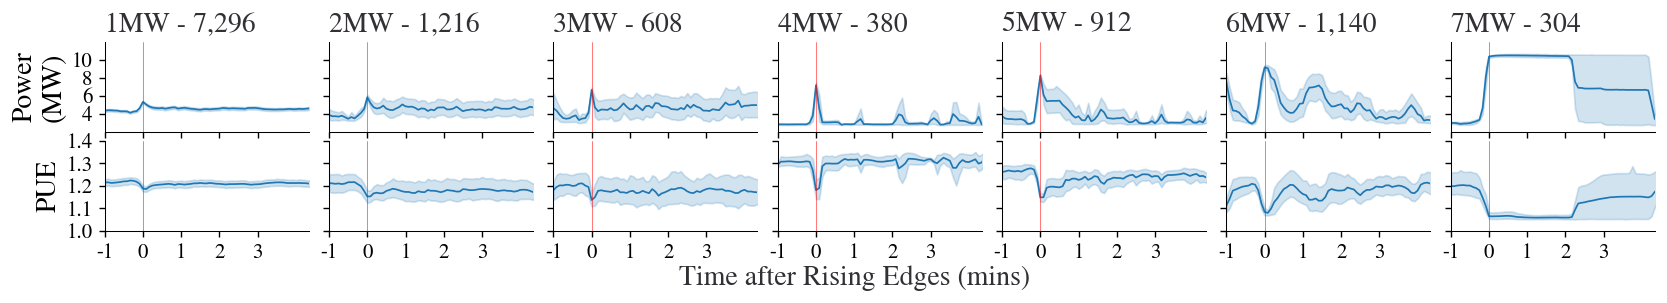

CPU times: user 28.2 s, sys: 2.06 s, total: 30.3 s
Wall time: 28.5 s


In [23]:
%%time
# initialize
rf_df = rf_df_summer
plt.close()

# Override acm-ieee-latex-pubstyle
plt.figure(figsize=(16, 2))
sns.despine(top=False, right=False)

# Layout
gs = mpl.gridspec.GridSpec(2, 7, height_ratios=[1, 1]) 
gs.update(hspace=0.1, wspace=0.1)

plt.xlabel('Time (minutes)', loc='center')

##################################################
# Comparison
def plot(rf_df, ax, amp_class, direction, metric, kwargs):
    mask = (
        (rf_df['type'] == direction) & (rf_df['amplitude_class_mw'] == amp_class)
    )
    df = rf_df[mask].reset_index()
    # TODO: Some massage (melting)
    sns.lineplot(ax=ax, data=df, x="index", y=metric,
                 sort=True, ci=95, **kwargs)
    
layout = [
    # Rise
    (0, gs[0, 0], 1, '1MW', 'rise', POWER),
    (1, gs[0, 1], 2, '2MW', 'rise', POWER),
    (2, gs[0, 2], 3, '3MW', 'rise', POWER),
    (3, gs[0, 3], 4, '4MW', 'rise', POWER),
    (4, gs[0, 4], 5, '5MW', 'rise', POWER),
    (5, gs[0, 5], 6, '6MW', 'rise', POWER),
    (6, gs[0, 6], 7, '7MW', 'rise', POWER),
    # Fall
    (7, gs[1, 0], 1, '1MW', 'rise', PUE),
    (8, gs[1, 1], 2, '2MW', 'rise', PUE),
    (9, gs[1, 2], 3, '3MW', 'rise', PUE),
    (10, gs[1, 3], 4, '4MW', 'rise', PUE),
    (11, gs[1, 4], 5, '5MW', 'rise', PUE),
    (12, gs[1, 5], 6, '6MW', 'rise', PUE),
    (13, gs[1, 6], 7, '7MW', 'rise', PUE),
]
for i, loc, amp_class, amp_label, direction, metric in layout:
    # Subplot item
    ax = plt.subplot(loc)
    kwargs = {
        "linewidth": 1,
        "legend": False,
    }
    # Count number of segments per amplitude class
    seg_count = rf_df[rf_df['type'] == 'rise'].groupby('amplitude_class_mw')['timestamp'].count()

    # Location customization
    if i not in [0, 7]:
        plt.setp(ax.get_yticklabels(), visible=False)
    if i in [0, 1, 2, 3, 4, 5, 6]:
        ax.set_title(f"{amp_label} - {seg_count[amp_class]:,}")
        plt.setp(ax.get_xticklabels(), visible=False)

    # Plot
    plot(rf_df, ax, amp_class, direction, metric, kwargs)
    
    # X ticks
    xtck = [0, 12, 24, 36, 48]  # ticks
    xlab = [-1, 0, 1, 2, 3]   # minutes
    ax.set_xlim([0, SEGMENT_REAR])
    ax.set_xticks(xtck)
    ax.set_xticklabels(xlab)
    ax.set_xlabel("")
    
    if i in [0, 1, 2, 3, 4, 5, 6]:
        # Y ticks - Power in MW
        MW = 1000000
        ytck = [4 * MW, 6 * MW, 8 * MW, 10 * MW]
        ytlb = [4, 6, 8, 10]
        ylim = [2000000, 12000000]
        ylab = "Power\n(MW)"
    else:
        # Y ticks - PUE
        ytck = [1.0, 1.1, 1.2, 1.3, 1.4]
        ytlb = [1.0, 1.1, 1.2, 1.3, 1.4]
        ylim = [1.0, 1.4]
        ylab = "PUE"
        
    ax.set_ylim(ylim)
    ax.set_yticks(ytck)
    ax.set_yticklabels(ytlb)
    ax.set_ylabel(ylab)

    # Overlay
    ax.axvline(SEGMENT_FRONT, color='r', linewidth=0.3)

fig = plt.gcf()
fig.text(0.5, -0.09, 'Time after Rising Edges (mins)', ha='center')
    
plt.subplots_adjust(hspace=.0)
plt.savefig("../plots/power_dynamics_per_amp_summer.pdf", format="pdf", bbox_inches='tight', pad_inches=0.01)
plt.show()

# Power Dynamics - Full Year

## Full year power dynamics

This one will be the substitute for the rise / fall edge power graphs.  Should give a more comprehensive view.
Will be using a 16 x 4 strip for this one

In [15]:
%%time
# Get all the rise & falling segments
rise_df = get_segments(date_keys_only_power, direction="rise")
fall_df = get_segments(date_keys_only_power, direction="fall")

rise_df['type'] = "rise"
fall_df['type'] = "fall"
rf_df_fullyr = pd.concat([rise_df, fall_df])

Segments collected: rise 7746, [3, 3, 11, 15, 44, 8, 72, 43, 27, 2, 9, 5, 1, 13, 6, 4, 23, 28, 4, 1, 33, 2, 22, 26, 14, 8, 13, 26, 8, 6, 8, 52, 4, 50, 13, 2, 4, 5, 10, 1, 19, 27, 22, 1, 11, 3, 2, 7, 38, 32, 46, 25, 105, 57, 184, 242, 144, 20, 19, 24, 134, 53, 35, 219, 199, 230, 19, 44, 41, 168, 195, 298, 96, 86, 116, 14, 11, 16, 9, 9, 4, 9, 6, 14, 4, 1, 1, 3, 6, 7, 6, 3, 4, 27, 58, 1, 8, 2, 112, 13, 10, 389, 34, 8, 70, 130, 114, 6, 24, 15, 9, 21, 6, 25, 10, 1, 8, 4, 96, 6, 123, 22, 260, 9, 31, 18, 10, 2, 3, 25, 8, 13, 29, 50, 24, 10, 33, 27, 76, 3, 2, 7, 12, 25, 6, 28, 2, 1, 2, 8, 24, 13, 12, 5, 4, 14, 1, 7, 104, 3, 5, 4, 22, 3, 1, 5, 4, 5, 18, 149, 2, 6, 5, 58, 270, 58, 4, 12, 7, 23, 10, 13, 113, 36, 177, 3, 2, 3, 7, 4, 1, 19, 3, 7, 78, 16, 1, 28, 4, 10, 20, 8, 3, 34, 36, 34, 30, 232, 3, 8, 55, 58, 4, 14, 16, 4, 3, 7, 1]
Segments survived: rise 204
Segments collected: fall 7351, [4, 3, 4, 3, 2, 12, 15, 29, 3, 9, 65, 50, 27, 8, 5, 13, 7, 4, 21, 19, 4, 1, 37, 23, 26, 13, 10, 15, 33, 7, 

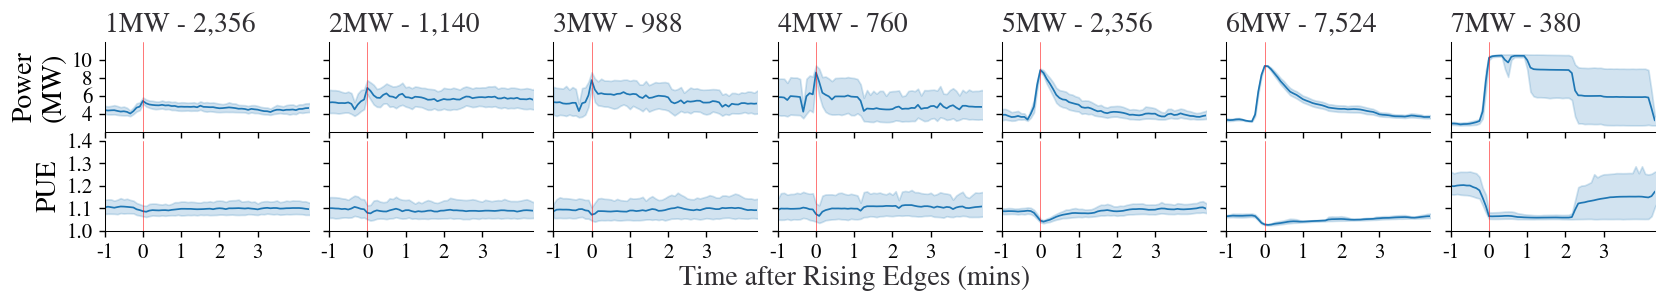

CPU times: user 27.5 s, sys: 1.8 s, total: 29.3 s
Wall time: 27.8 s


In [24]:
%%time
# initialize
rf_df = rf_df_fullyr
plt.close()

# Override acm-ieee-latex-pubstyle
plt.figure(figsize=(16, 2))
sns.despine(top=False, right=False)

# Layout
gs = mpl.gridspec.GridSpec(2, 7, height_ratios=[1, 1]) 
gs.update(hspace=0.1, wspace=0.1)

plt.xlabel('Time (minutes)', loc='center')

##################################################
# Comparison
def plot(rf_df, ax, amp_class, direction, metric, kwargs):
    mask = (
        (rf_df['type'] == direction) & (rf_df['amplitude_class_mw'] == amp_class)
    )
    df = rf_df[mask].reset_index()
    # TODO: Some massage (melting)
    sns.lineplot(ax=ax, data=df, x="index", y=metric,
                 sort=True, ci=95, **kwargs)
    
layout = [
    # Rise
    (0, gs[0, 0], 1, '1MW', 'rise', POWER),
    (1, gs[0, 1], 2, '2MW', 'rise', POWER),
    (2, gs[0, 2], 3, '3MW', 'rise', POWER),
    (3, gs[0, 3], 4, '4MW', 'rise', POWER),
    (4, gs[0, 4], 5, '5MW', 'rise', POWER),
    (5, gs[0, 5], 6, '6MW', 'rise', POWER),
    (6, gs[0, 6], 7, '7MW', 'rise', POWER),
    # Fall
    (7, gs[1, 0], 1, '1MW', 'rise', PUE),
    (8, gs[1, 1], 2, '2MW', 'rise', PUE),
    (9, gs[1, 2], 3, '3MW', 'rise', PUE),
    (10, gs[1, 3], 4, '4MW', 'rise', PUE),
    (11, gs[1, 4], 5, '5MW', 'rise', PUE),
    (12, gs[1, 5], 6, '6MW', 'rise', PUE),
    (13, gs[1, 6], 7, '7MW', 'rise', PUE),
]
for i, loc, amp_class, amp_label, direction, metric in layout:
    # Subplot item
    ax = plt.subplot(loc)
    kwargs = {
        "linewidth": 1,
        "legend": False,
    }
    # Count number of segments per amplitude class
    seg_count = rf_df[rf_df['type'] == 'rise'].groupby('amplitude_class_mw')['timestamp'].count()

    # Location customization
    if i not in [0, 7]:
        plt.setp(ax.get_yticklabels(), visible=False)
    if i in [0, 1, 2, 3, 4, 5, 6]:
        ax.set_title(f"{amp_label} - {seg_count[amp_class]:,}")
        plt.setp(ax.get_xticklabels(), visible=False)

    # Plot
    plot(rf_df, ax, amp_class, direction, metric, kwargs)
    
    # X ticks
    xtck = [0, 12, 24, 36, 48]  # ticks
    xlab = [-1, 0, 1, 2, 3]   # minutes
    ax.set_xlim([0, SEGMENT_REAR])
    ax.set_xticks(xtck)
    ax.set_xticklabels(xlab)
    ax.set_xlabel("")
    
    if i in [0, 1, 2, 3, 4, 5, 6]:
        # Y ticks - Power in MW
        MW = 1000000
        ytck = [4 * MW, 6 * MW, 8 * MW, 10 * MW]
        ytlb = [4, 6, 8, 10]
        ylim = [2000000, 12000000]
        ylab = "Power\n(MW)"
    else:
        # Y ticks - PUE
        ytck = [1.0, 1.1, 1.2, 1.3, 1.4]
        ytlb = [1.0, 1.1, 1.2, 1.3, 1.4]
        ylim = [1.0, 1.4]
        ylab = "PUE"
        
    ax.set_ylim(ylim)
    ax.set_yticks(ytck)
    ax.set_yticklabels(ytlb)
    ax.set_ylabel(ylab)

    # Overlay
    ax.axvline(SEGMENT_FRONT, color='r', linewidth=0.3)

fig = plt.gcf()
fig.text(0.5, -0.09, 'Time after Rising Edges (mins)', ha='center')

plt.subplots_adjust(hspace=.0)
plt.savefig("../plots/power_dynamics_per_amp_fullyr.pdf", format="pdf", bbox_inches='tight', pad_inches=0.01)
plt.show()